### CSCI 6364 - Machine Learning
_Written by: Huru Algayeva_

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import rasterio
import requests
from bs4 import BeautifulSoup
import urllib.request
from tqdm import tqdm
from sklearn.metrics import f1_score
from urllib.parse import urljoin
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
#I created a class named DataLoader.
#It's like a blueprint for a tool that helps me fetch and save satellite and map images.
class DataLoader:
    def __init__(self, sat_url, map_url, save_dir):
        self.sat_url = sat_url
        self.map_url = map_url
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def get_tiff_links(self, url):
        """Get TIFF file links from the webpage."""
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        tiff_links = [link.get('href') for link in soup.find_all('a')
                     if link.get('href', '').lower().endswith(('.tiff', '.tif'))]
        base_url = '/'.join(url.split('/')[:-1])
        return [urljoin(base_url + '/', link) for link in tiff_links]

    def download_tiff(self, url, subdir):
        """Download a TIFF file."""
        save_path = os.path.join(self.save_dir, subdir, url.split('/')[-1])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        if not os.path.exists(save_path):
            urllib.request.urlretrieve(url, save_path)
        return save_path

    def load_dataset(self):
        """Download and load both satellite and map images."""
        # Download images
        sat_links = self.get_tiff_links(self.sat_url)
        map_links = self.get_tiff_links(self.map_url)

        print("Downloading satellite images...")
        sat_paths = [self.download_tiff(url, 'sat') for url in tqdm(sat_links)]
        print("Downloading map images...")
        map_paths = [self.download_tiff(url, 'map') for url in tqdm(map_links)]

        return sorted(sat_paths), sorted(map_paths)

In [ ]:
class TiffGenerator(tf.keras.utils.Sequence):
    def __init__(self, sat_paths, map_paths, batch_size=8, img_size=(384, 384), augment=False):
        self.sat_paths = sat_paths
        self.map_paths = map_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.sat_paths) // self.batch_size

    def read_tiff(self, path):
        """Read and preprocess TIFF file."""
        with rasterio.open(path) as src:
            image = src.read()
            image = np.transpose(image, (1, 2, 0))
            # Convert to numpy array before resizing
            image = np.array(image)
            if len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)
            image = tf.image.resize(image, self.img_size)
            return image.numpy()  # Convert back to numpy array

    def augment_data(self, image, mask):
        """Apply data augmentation."""
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        return image.numpy(), mask.numpy()  # Convert back to numpy arrays

    def __getitem__(self, idx):
        batch_sat_paths = self.sat_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_map_paths = self.map_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for sat_path, map_path in zip(batch_sat_paths, batch_map_paths):
            # Load and preprocess images
            image = self.read_tiff(sat_path)
            image = image / 255.0  # Normalize

            mask = self.read_tiff(map_path)
            mask = np.where(mask > 128, 1, 0).astype(np.float32)  # Fixed thresholding

            if self.augment:
                image, mask = self.augment_data(tf.convert_to_tensor(image), tf.convert_to_tensor(mask))

            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

In [ ]:
def create_unet(input_shape=(384, 384, 3)):
    """Create U-Net model architecture."""
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.Dropout(0.5)(conv4)

    # Decoder
    up5 = layers.concatenate([layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def dice_loss(y_true, y_pred):
    """Calculate Dice loss."""
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
def combined_loss(y_true, y_pred):
    """Combine binary crossentropy and dice loss."""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [ ]:
# Dataset URLs
train_urls = {
    'sat': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html',
    'map': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/index.html'
}
valid_urls = {
    'sat': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/index.html',
    'map': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/index.html'
}
test_urls = {
    'sat': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/sat/index.html',
    'map': 'https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/map/index.html'
}

In [ ]:
# Load datasets
print("Loading training data...")
train_loader = DataLoader(train_urls['sat'], train_urls['map'], 'data/train')
train_sat_paths, train_map_paths = train_loader.load_dataset()

print("Loading validation data...")
valid_loader = DataLoader(valid_urls['sat'], valid_urls['map'], 'data/valid')
valid_sat_paths, valid_map_paths = valid_loader.load_dataset()

Loading training data...


100%|██████████| 1108/1108 [13:17<00:00,  1.39it/s]


100%|██████████| 1108/1108 [11:04<00:00,  1.67it/s]


Loading validation data...


100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


In [ ]:
# Create data generators
train_gen = TiffGenerator(train_sat_paths, train_map_paths, batch_size=8, augment=True)
valid_gen = TiffGenerator(valid_sat_paths, valid_map_paths, batch_size=8, augment=False)

In [ ]:
# Create and compile model
model = create_unet()
model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_iou_score',  # Updated metric name
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou_score',  # Updated metric name
        mode='max',  # Specify that we want to maximize IoU
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',  # Specify that we want to minimize loss
        verbose=1
    )
]

In [ ]:
# Train model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=callbacks)

# Save final model
model.save('final_model.keras')

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 100s 457ms/step - accuracy: 0.9140 - io_u: 0.0000e+00 - loss: 1.2581 - val_accuracy: 0.9257 - val_io_u: 0.0000e+00 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_iou_score available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: accuracy,io_u,loss,val_accuracy,val_io_u,val_loss
  current = self.get_monitor_value(logs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 418ms/step - accuracy: 0.9407 - io_u: 0.0000e+00 - loss: 1.0243 - val_accuracy: 0.8943 - val_io_u: 0.0000e+00 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 419ms/step - accuracy: 0.9265 - io_u: 0.0000e+00 - loss: 0.9730 - val_accuracy: 0.8805 - val_io_u: 0.0000e+00 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 416ms/step - accuracy: 0.9351 - io_u: 0.0000e+00 - loss: 0.9277 - val_accuracy: 0.9227 - val_io_u: 0.0000e+00 - val_loss: 0.8901 - learning_rate: 0.0010
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 415ms/step - accuracy: 0.9383 - io_u: 0.0000e+00 - loss: 0.8981 - val_accuracy: 0.9269 - val_io_u: 0.0000e+00 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 60s 416ms/step - accuracy: 0.9461 - io_u: 0.0000e+00 - loss: 0.8319 - val_accuracy: 0.9280 - val_io_u: 0.0000e+00 - val_loss: 0.9603 - learning_rate: 0.0010
Epoch 7/20
138/138 ━━━━━━━

In [ ]:
print("\nLoading test data...")
test_loader = DataLoader(test_urls['sat'], test_urls['map'], 'data/test')
test_sat_paths, test_map_paths = test_loader.load_dataset()
test_gen = TiffGenerator(test_sat_paths, test_map_paths, batch_size=8, augment=False)


Loading test data...


100%|██████████| 49/49 [00:00<00:00, 26795.42it/s]


100%|██████████| 49/49 [00:00<00:00, 58171.78it/s]


In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

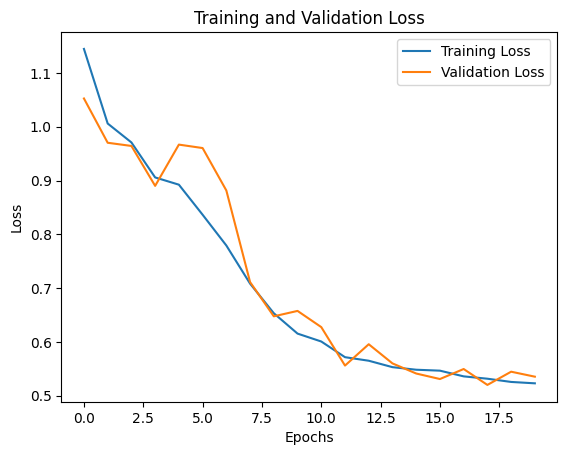

In [ ]:
plot_loss(history)

In [ ]:
test_images, test_masks = next(iter(test_gen))

predictions = model.predict(test_images)
thresholded_preds = (predictions > 0.5).astype(np.uint8)

iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(test_masks.flatten(), thresholded_preds.flatten())
print(f"Test IoU: {iou_metric.result().numpy():.4f}")

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test IoU: 0.7470


In [ ]:
y_true = test_masks.flatten()
y_pred = thresholded_preds.flatten()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6609
Recall: 0.7100
F1 Score: 0.6846


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


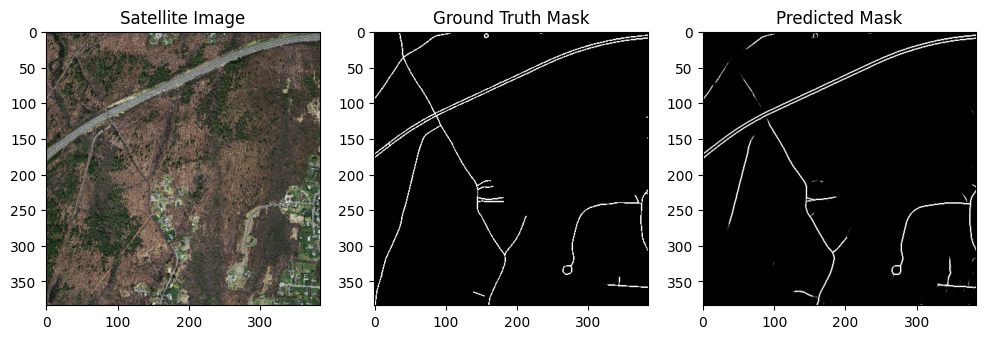

In [ ]:
sat_img, map_gt = next(iter(test_gen))
map_pred = model.predict(sat_img)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Satellite Image")
plt.imshow(sat_img[0].squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(map_gt[0].squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(map_pred[0].squeeze(), cmap='gray')
plt.show()